# Import fabric library

In [9]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()

In [10]:
slice_name="file-project_" + fablib.get_bastion_username()

node_conf = [
    {'name': "client1",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools', 'iperf3', 'moreutils']},
    {'name': "client2",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools', 'iperf3', 'moreutils']},
    {'name': "client3",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
    {'name': "client4",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
    {'name': "client5",   'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
    {'name': "currentServer",  'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "hotServer",  'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}, 
    {'name': "router",  'cores': 2, 'ram': 4, 'disk': 20, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}
]
net_conf = [
    {"name": "net0", "subnet": "10.0.0.0/24", "nodes": [{"name": "client1",   "addr": "10.0.0.2"}, {"name": "router", "addr": "10.0.0.1"}]},
    {"name": "net1", "subnet": "10.0.1.0/24", "nodes": [{"name": "client2",   "addr": "10.0.1.2"}, {"name": "router", "addr": "10.0.1.1"}]},
    {"name": "net2", "subnet": "10.0.2.0/24", "nodes": [{"name": "client3",   "addr": "10.0.2.2"}, {"name": "router", "addr": "10.0.2.1"}]},
    {"name": "net3", "subnet": "10.0.3.0/24", "nodes": [{"name": "client4",   "addr": "10.0.3.2"}, {"name": "router", "addr": "10.0.3.1"}]},
    {"name": "net4", "subnet": "10.0.4.0/24", "nodes": [{"name": "client5",   "addr": "10.0.4.2"}, {"name": "router", "addr": "10.0.4.1"}]},
    {"name": "net5", "subnet": "10.0.5.0/24", "nodes": [{"name": "currentServer",   "addr": "10.0.5.2"}, {"name": "router", "addr": "10.0.5.1"}]},
    {"name": "net6", "subnet": "10.0.6.0/24", "nodes": [{"name": "hotServer",   "addr": "10.0.6.2"}, {"name": "router", "addr": "10.0.6.1"}]},
]
route_conf = [
    {"addr": "10.0.5.0/24", "gw": "10.0.0.1", "nodes": ["client1"]}, 
    {"addr": "10.0.5.0/24", "gw": "10.0.1.1", "nodes": ["client2"]},
    {"addr": "10.0.5.0/24", "gw": "10.0.2.1", "nodes": ["client3"]},
    {"addr": "10.0.5.0/24", "gw": "10.0.3.1", "nodes": ["client4"]},
    {"addr": "10.0.6.0/24", "gw": "10.0.4.1", "nodes": ["client5"]},
    {"addr": "10.0.0.0/24", "gw": "10.0.5.1", "nodes": ["currentServer"]},
    {"addr": "10.0.1.0/24", "gw": "10.0.5.1", "nodes": ["currentServer"]},
    {"addr": "10.0.2.0/24", "gw": "10.0.5.1", "nodes": ["currentServer"]},
    {"addr": "10.0.3.0/24", "gw": "10.0.5.1", "nodes": ["currentServer"]},
    {"addr": "10.0.4.0/24", "gw": "10.0.6.1", "nodes": ["hotServer"]},
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

In [11]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named file-project_ctsai61_0000154734 yet.
Continue to the next step to make one.


In [12]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,RUTG
State,Active
Address,"120 Avenue E,Piscataway, New Jersey"
Location,"(40.5235278, -74.4432487)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,531
Cores Capacity,640
Cores Allocated,109
RAM Available,2160


'<pandas.io.formats.style.Styler object at 0x7f2a04611f00>'

In [13]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [14]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

# MFLIB

In [15]:
import os
import json
import traceback
# Check version
import mflib 
print(f"MFLib version  {mflib.__version__} " )

# Import MFLib Class
from mflib.mflib import MFLib

MFLib version  1.0.4 


## Initialize

In [16]:
%%time
MFLib.addMeasNode(slice, disk=100)

CPU times: user 721 ms, sys: 1.13 ms, total: 722 ms
Wall time: 721 ms


In [17]:
slice.submit()


Retry: 15, Time: 1098 sec


ID,3a4e1273-f392-4d2d-976f-ac04d5994094
Name,file-project_ctsai61_0000154734
Lease Expiration (UTC),2024-04-30 05:00:22 +0000
Lease Start (UTC),2024-04-29 05:00:24 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
27face13-79a3-4d75-934d-4540ef19cb89,client1,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe63:f099,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe63:f099,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
4cb7ed13-3d71-4852-a530-2026a088d897,client2,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fedb:e6e,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fedb:e6e,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
1dd1dc1e-51a6-47a3-9cc4-88c8a7280fbc,client3,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe2a:830b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe2a:830b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
fa0a1455-1ea6-4bf3-800b-0177c9f68b6d,client4,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feac:579b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feac:579b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
f218e1a5-f797-41ec-bf48-2f4279c3e370,client5,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe00:73d,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe00:73d,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
8e145420-f018-4422-bbef-045bf4819c3e,currentServer,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe64:f5d8,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe64:f5d8,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
b64a5a1e-a115-45d3-93e2-caf862b2d317,hotServer,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe5c:3556,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe5c:3556,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
07cab38b-3511-48c6-8210-9fe56e9b6905,meas-node,4,16,100,default_ubuntu_20,qcow2,edc-w1.fabric-testbed.net,EDC,ubuntu,2620:0:c80:1003:f816:3eff:fe8c:1853,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe8c:1853,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
5817c40c-0553-4386-a81d-97a7bf9cc12e,router,2,4,100,default_ubuntu_22,qcow2,rutg-w2.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fec9:c542,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fec9:c542,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
f3e67ec0-8688-4ba2-b9df-3e34e74d93d7,l3_meas_net_EDC,L3,FABNetv4,EDC,10.132.140.0/24,10.132.140.1,Active,
ff4ec078-2541-4ab3-bd4d-282778119623,l3_meas_net_RUTG,L3,FABNetv4,RUTG,10.141.19.0/24,10.141.19.1,Active,
b9211eac-fa81-40e8-83ca-9361555cefa0,net0,L2,L2Bridge,RUTG,None,None,Active,
01768ed1-69fd-4171-9568-92649cf034fe,net1,L2,L2Bridge,RUTG,None,None,Active,
f4fc1258-0de1-42bf-827c-59d89ac4ea39,net2,L2,L2Bridge,RUTG,None,None,Active,
2fd479fc-66e0-470b-b9b6-d11eeb7f00c7,net3,L2,L2Bridge,RUTG,None,None,Active,
436380e3-3955-4cdd-bd9e-198b7e777e36,net4,L2,L2Bridge,RUTG,None,None,Active,
43c9084e-f599-4e22-bc46-6cb255f47673,net5,L2,L2Bridge,RUTG,None,None,Active,
a75cb130-a1f1-441d-96c7-2202f524a032,net6,L2,L2Bridge,RUTG,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
client1-net0-p1,p1,client1,net0,100,config,,0A:04:79:AA:28:A0,enp7s0,enp7s0,None,6
client1-meas_nic_client1_RUTG-p1,p1,client1,l3_meas_net_RUTG,100,config,,0A:40:79:F2:9C:86,enp8s0,enp8s0,None,6
client2-meas_nic_client2_RUTG-p1,p1,client2,l3_meas_net_RUTG,100,config,,22:23:58:42:8C:95,enp8s0,enp8s0,None,6
client2-net1-p1,p1,client2,net1,100,config,,1E:EF:83:83:AD:61,enp7s0,enp7s0,None,6
client3-net2-p1,p1,client3,net2,100,config,,12:11:49:FD:E9:B8,enp8s0,enp8s0,None,6
client3-meas_nic_client3_RUTG-p1,p1,client3,l3_meas_net_RUTG,100,config,,0E:89:D3:27:78:09,enp7s0,enp7s0,None,6
client4-meas_nic_client4_RUTG-p1,p1,client4,l3_meas_net_RUTG,100,config,,1E:C7:45:70:67:5D,enp8s0,enp8s0,None,6
client4-net3-p1,p1,client4,net3,100,config,,1A:41:10:74:C0:DA,enp7s0,enp7s0,None,6
client5-meas_nic_client5_RUTG-p1,p1,client5,l3_meas_net_RUTG,100,config,,12:52:62:26:67:E1,enp7s0,enp7s0,None,6
client5-net4-p1,p1,client5,net4,100,config,,16:1C:3F:16:22:45,enp8s0,enp8s0,None,6



Time to print interfaces 1129 seconds


'3a4e1273-f392-4d2d-976f-ac04d5994094'

In [18]:
slice = fablib.get_slice(name=slice_name)

## Install packages on all nodes in slices

In [19]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

## Bring interface up

In [20]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [21]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        #print("echo %s | sudo tee -a /etc/hosts" % h)
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.0.0.2 client1
10.0.0.1 router
10.0.1.2 client2
10.0.1.1 router
10.0.2.2 client3
10.0.2.1 router
10.0.3.2 client4
10.0.3.1 router
10.0.4.2 client5
10.0.4.1 router
10.0.5.2 currentServer
10.0.5.1 router
10.0.6.2 hotServer
10.0.6.1 router
10.0.0.2 client1
10.0.0.1 router
10.0.1.2 client2
10.0.1.1 router
10.0.2.2 client3
10.0.2.1 router
10.0.3.2 client4
10.0.3.1 router
10.0.4.2 client5
10.0.4.1 router
10.0.5.2 currentServer
10.0.5.1 router
10.0.6.2 hotServer
10.0.6.1 router
10.0.0.2 client1
10.0.0.1 router
10.0.1.2 client2
10.0.1.1 router
10.0.2.2 client3
10.0.2.1 router
10.0.3.2 client4
10.0.3.1 router
10.0.4.2 client5
10.0.4.1 router
10.0.5.2 currentServer
10.0.5.1 router
10.0.6.2 hotServer
10.0.6.1 router
10.0.0.2 client1
10.0.0.1 router
10.0.1.2 client2
10.0.1.1 router
10.0.2.2 client3
10.0.2.1 router
10.0.3.2 client4
10.0.3.1 router
10.0.4.2 client5
10.0.4.1 router
10.0.5.2 currentServer
10.0.5.1 router
10.0.6.2 hotServer
10.0.6.1 router
10.0.0.2 client1
10.0.0.1 router
10.0.1.2 cl

In [22]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [23]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

## Drow topology

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

In [25]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

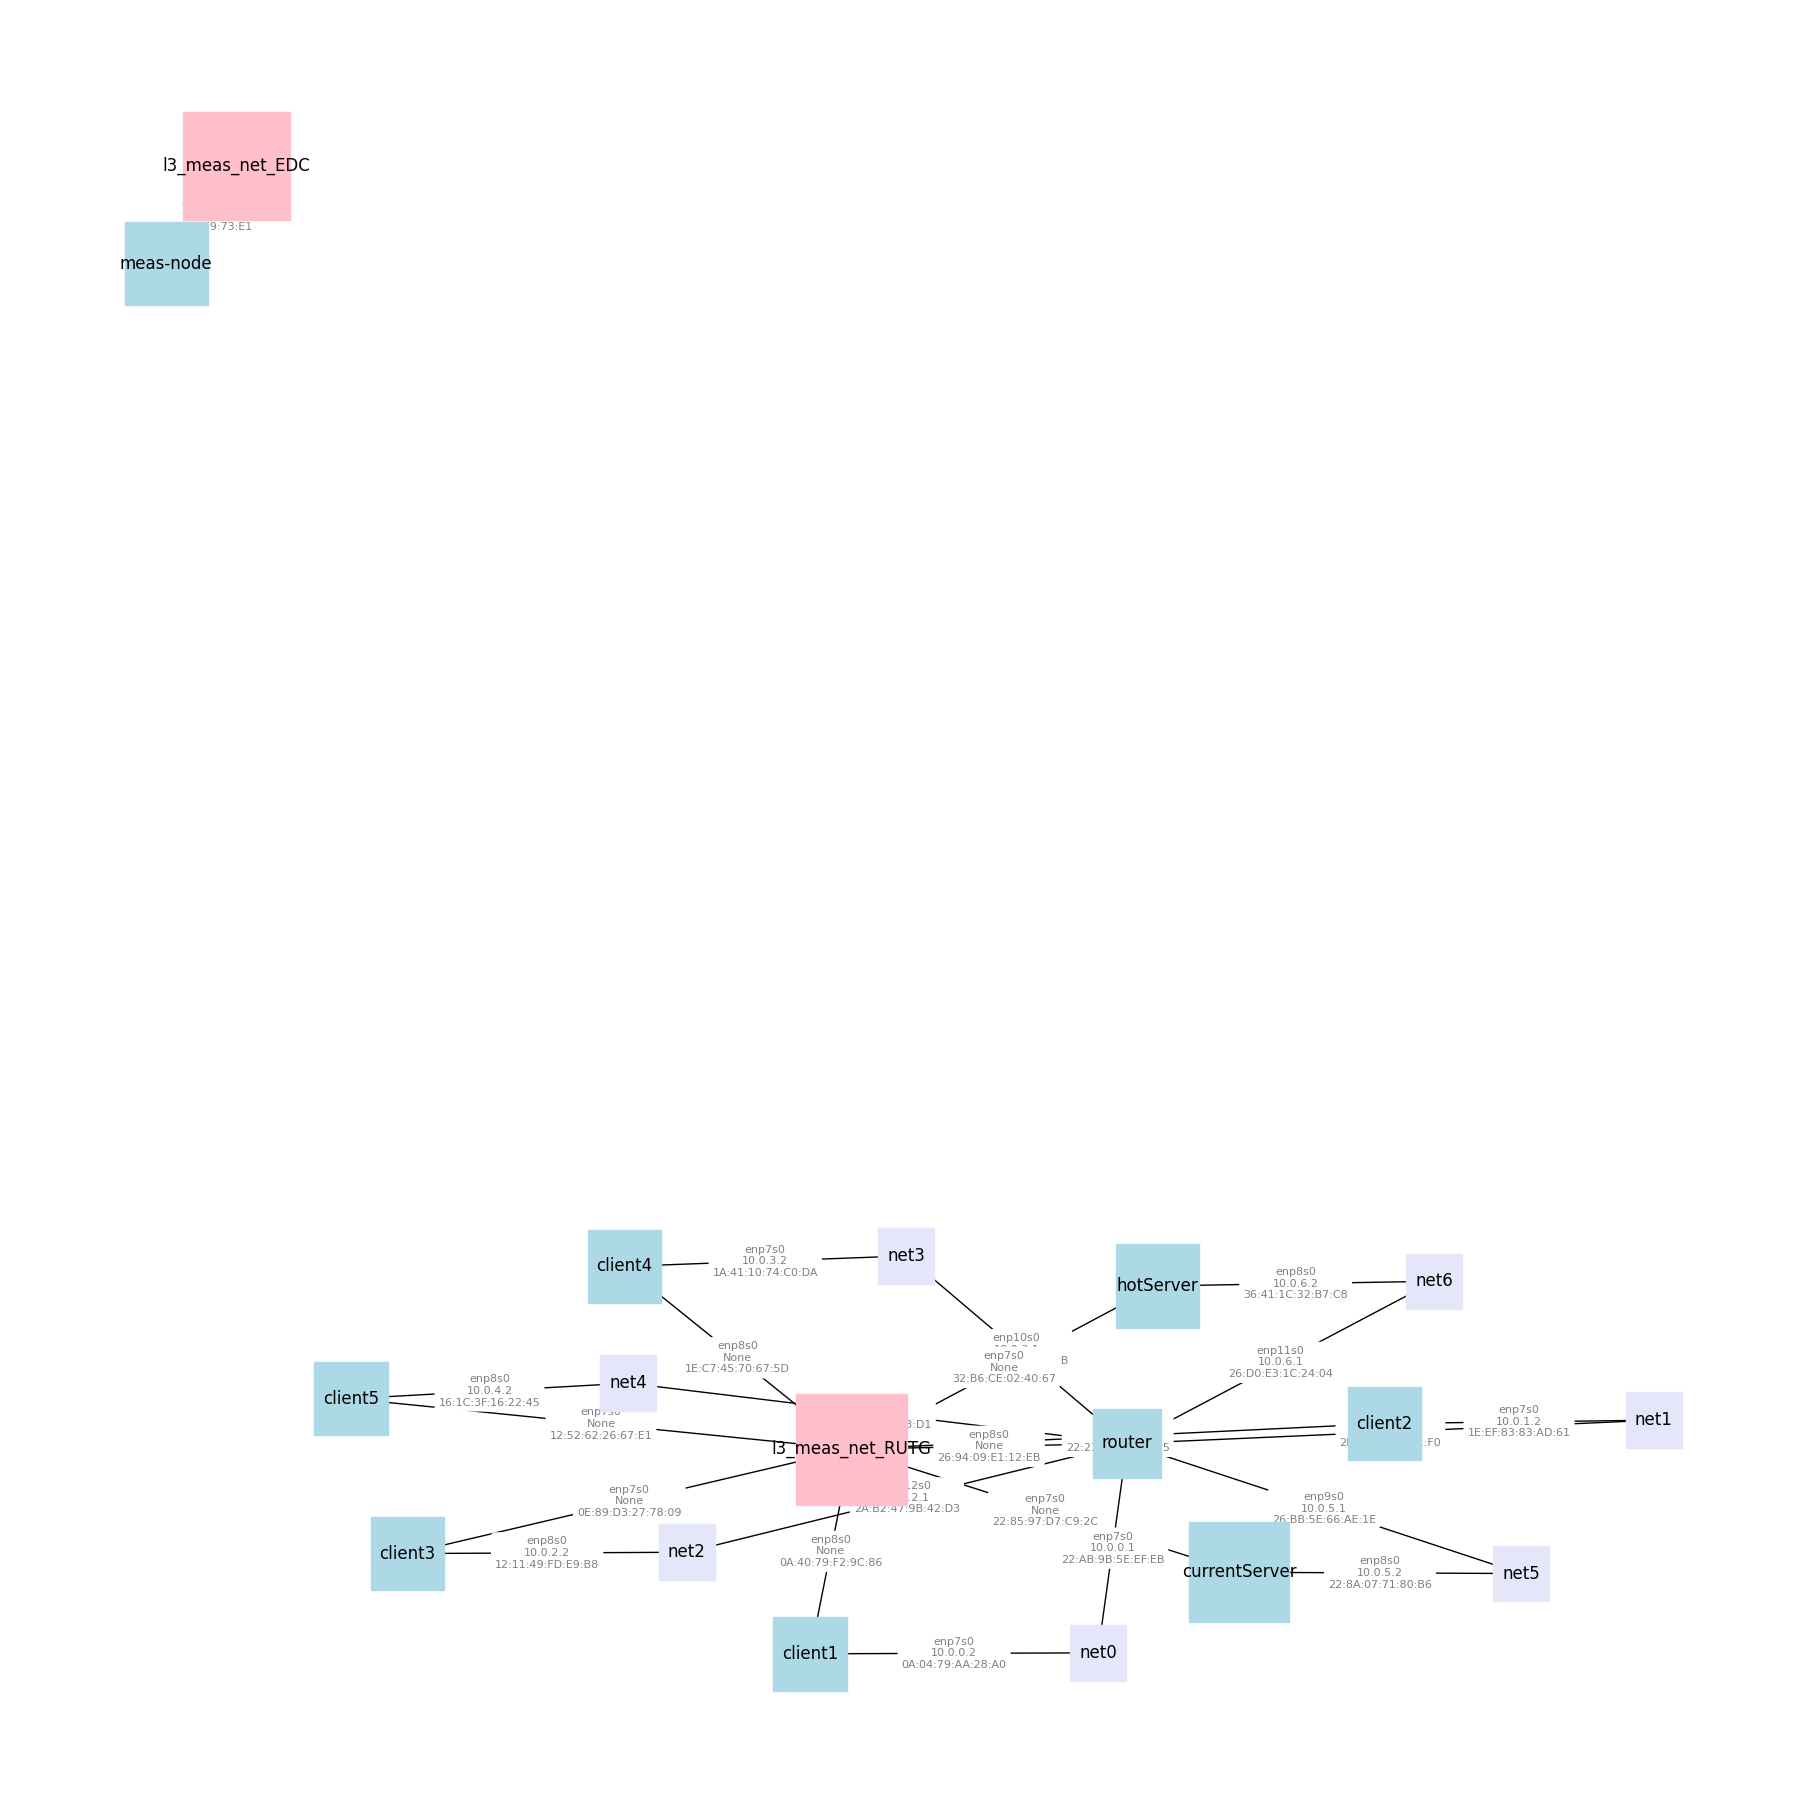

In [26]:

plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [27]:
%%time
mf = MFLib(slice_name)

Inititializing slice "file-project_ctsai61_0000154734" for MeasurementFramework.
Found meas node as meas-node at 2620:0:c80:1003:f816:3eff:fe8c:1853
Bootstrap status not found. Will now start bootstrap process...
Generating MFUser Keys...
MFUser key generation Done.
Installing mfuser account...
Installing mfuser account done.
Cloning Measurement Framework Repository from github.com...
Cloning Measurement Framework Repository from github.com done.
Configuring Measurement Network...
Measurement Network setup complete.
Generating Ansible Inventory for Measurement Framework Deployment...
Ansible Inventory for Measurement Framework Deployment generated and saved.
Bootstrapping measurement node via bash...
Starting Bootstrap Process on Measure Node (bash script)...
Bootstrap Process on Measure Node (bash script) done.
Bootstrapping measurement node via ansible...
Starting Bootstrap Process on Measure Node (Ansible Playbook)...
Bootstrap Process on Measure Node (Ansible Playbook) done.
Bootst

In [28]:
meas_node_name = mf.measurement_node_name
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")
print (slice)

try:
    meas_node = slice.get_node(name=meas_node_name)
    client1 = slice.get_node(name="client1")
    client2 = slice.get_node(name="client2")
    client3 = slice.get_node(name="client3")
    client4 = slice.get_node(name="client4")
    client5 = slice.get_node(name="client5")
    currentServer = slice.get_node(name="currentServer")
    hotServer = slice.get_node(name="hotServer")
    router = slice.get_node(name="router")

except Exception as e:
    print(f"Fail: {e}")   
print (meas_node)

-----------  ------------------------------------
Slice Name   file-project_ctsai61_0000154734
Slice ID     3a4e1273-f392-4d2d-976f-ac04d5994094
Slice State  StableOK
Lease End    2024-04-30 05:00:22 +0000
-----------  ------------------------------------
-----------------  -----------------------------------------------------------------------------------------------------------------------------------------
ID                 07cab38b-3511-48c6-8210-9fe56e9b6905
Name               meas-node
Cores              4
RAM                16
Disk               100
Image              default_ubuntu_20
Image Type         qcow2
Host               edc-w1.fabric-testbed.net
Site               EDC
Management IP      2620:0:c80:1003:f816:3eff:fe8c:1853
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe8c:1853
-----------------  -----------------------------------

## Check Whether the Nodes are on PTP-capable Sites 

In [29]:
ptp_capable_sites=['STAR','MAX','MICH','MASS','UTAH','NCSA','UCSD','FIU','CLEM','CERN','INDI']
nodes_on_ptp_sites=[]
for node in slice.get_nodes():
    site=node.get_site()
    name=node.get_name()
    if (site in ptp_capable_sites):
        print (f"{name} on {site} is ptp capable")
        nodes_on_ptp_sites.append(node)
    else:
        print (f"{name} on {site} is not ptp capable")

client1 on RUTG is not ptp capable
client2 on RUTG is not ptp capable
client3 on RUTG is not ptp capable
client4 on RUTG is not ptp capable
client5 on RUTG is not ptp capable
currentServer on RUTG is not ptp capable
hotServer on RUTG is not ptp capable
router on RUTG is not ptp capable
meas-node on EDC is not ptp capable


In [30]:
cmd = f"sudo hostnamectl set-hostname `cat /var/lib/cloud/data/previous-hostname`"
for node in [client1, client2, client3, client4, client5, currentServer, hotServer, router]:
    node.execute(cmd)

## Setup timestamp service on nodes

### Pull the timestamp docker image to nodes (via ansible scripts on Measurement Node)

In [31]:
%%time
mf.create(service="timestamp")

CPU times: user 871 ms, sys: 26.4 ms, total: 897 ms
Wall time: 46 s


{'msg': 'Timestamp create playbook ran..',
 'success': True,
 'play_recap': 'PLAY RECAP *********************************************************************\nclient1                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient2                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient3                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient4                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient5                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \ncurrentServer              : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nhotServer                  : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nrouter  

### Run the timestamp docker image as a container on each experiment node

In [32]:
# Runs the image as Docker Container  
mf.start(services=["timestamp",])

[{'service': 'timestamp',
  'results': {'msg': 'Timestamp start playbook ran..',
   'success': True,
   'play_recap': 'PLAY RECAP *********************************************************************\nclient1                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient2                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient3                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient4                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nclient5                    : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \ncurrentServer              : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   \nhotServer                  : ok=2    changed=1    unreachable=0    failed=0    skippe

### Check on each Node if timestamp docker container is running

In [33]:
command = f"sudo docker ps"
stdout, stderr= client1.execute(command)
stdout, stderr= client2.execute(command)
stdout, stderr= client3.execute(command)
stdout, stderr= client4.execute(command)
stdout, stderr= client5.execute(command)

stdout, stderr= currentServer.execute(command)
stdout, stderr= hotServer.execute(command)
stdout, stderr= router.execute(command)

CONTAINER ID   IMAGE                           COMMAND     CREATED         STATUS         PORTS     NAMES
700d8c837725   fabrictestbed/timestamp:0.1.1   "python3"   3 seconds ago   Up 2 seconds             timestamp
CONTAINER ID   IMAGE                           COMMAND     CREATED         STATUS         PORTS     NAMES
0abb756ff249   fabrictestbed/timestamp:0.1.1   "python3"   5 seconds ago   Up 5 seconds             timestamp
CONTAINER ID   IMAGE                           COMMAND     CREATED         STATUS         PORTS     NAMES
0ba4f89f09e6   fabrictestbed/timestamp:0.1.1   "python3"   7 seconds ago   Up 6 seconds             timestamp
CONTAINER ID   IMAGE                           COMMAND     CREATED         STATUS         PORTS     NAMES
103fb2f48d7a   fabrictestbed/timestamp:0.1.1   "python3"   8 seconds ago   Up 8 seconds             timestamp
CONTAINER ID   IMAGE                           COMMAND     CREATED          STATUS          PORTS     NAMES
4c3ed02cbb32   fabrictestbed

## Create the object and set experiment name


In [34]:
from mflib.mf_timestamp import mf_timestamp
container_name="timestamp"
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)
packet_test_name = "packet_test"
event_test_name= "event_test"

<font color=blue size="6">*Timestamping Packets*</font>
### This method will first trigger tcpdump to record packets and then process the results

### Find an interface for the experiment on server to monitor traffic

In [35]:
try:
    currentServer_interfaces = currentServer.get_interfaces()
    for iface in currentServer_interfaces:
        if ("l3_meas_net" in iface.get_network().get_name()):
            print (f"The meas_net interface on currentServer is {iface.get_physical_os_interface_name()}")
except Exception as e:
    print(f"Fail: {e}")

The meas_net interface on currentServer is enp7s0


### Record timestamp for packets

In [36]:
# Check the interface ens/eth on that node and pass it as a parameter
# Check the interface IP type to specify IP version
ts.record_packet_timestamp(node=currentServer,name=packet_test_name, interface="enp8s0",ipversion="4",
                           protocol="tcp", duration="240", verbose=True)

Fail: Node not found: -----------------  -----------------------------------------------------------------------------------------------------------------------------------------
ID                 8e145420-f018-4422-bbef-045bf4819c3e
Name               currentServer
Cores              2
RAM                4
Disk               100
Image              default_ubuntu_22
Image Type         qcow2
Host               rutg-w2.fabric-testbed.net
Site               RUTG
Management IP      2620:0:d61:4101:f816:3eff:fe64:f5d8
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe64:f5d8
-----------------  -----------------------------------------------------------------------------------------------------------------------------------------
The docker command is: sudo docker exec -i timestamp python3 /root/services/timestamp/service_files/timestamptool.py record pa

### Get the recorded packet timestamp from local file

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
# packet_records= ts.get_packet_timestamp(node="currentServer", name=packet_test_name)

### Download the timestamp data file from currentServer

In [38]:
timestamp_volume= "/home/rocky/services/timestamp/output"
# Specify your Jupyterhub download path
file_download_path="/home/fabric/work/final_project/packet_timestamp.json"
file_content = ts.download_timestamp_file(node="currentServer", data_type="packet_timestamp",
                           local_file=file_download_path,
                           bind_mount_volume=timestamp_volume)

In [39]:
# A list of json objects, inspect the first object
file_download_path="/home/fabric/work/final_project/packet_timestamp.json"
with open(file_download_path, 'r') as f:
    result = json.load(f)


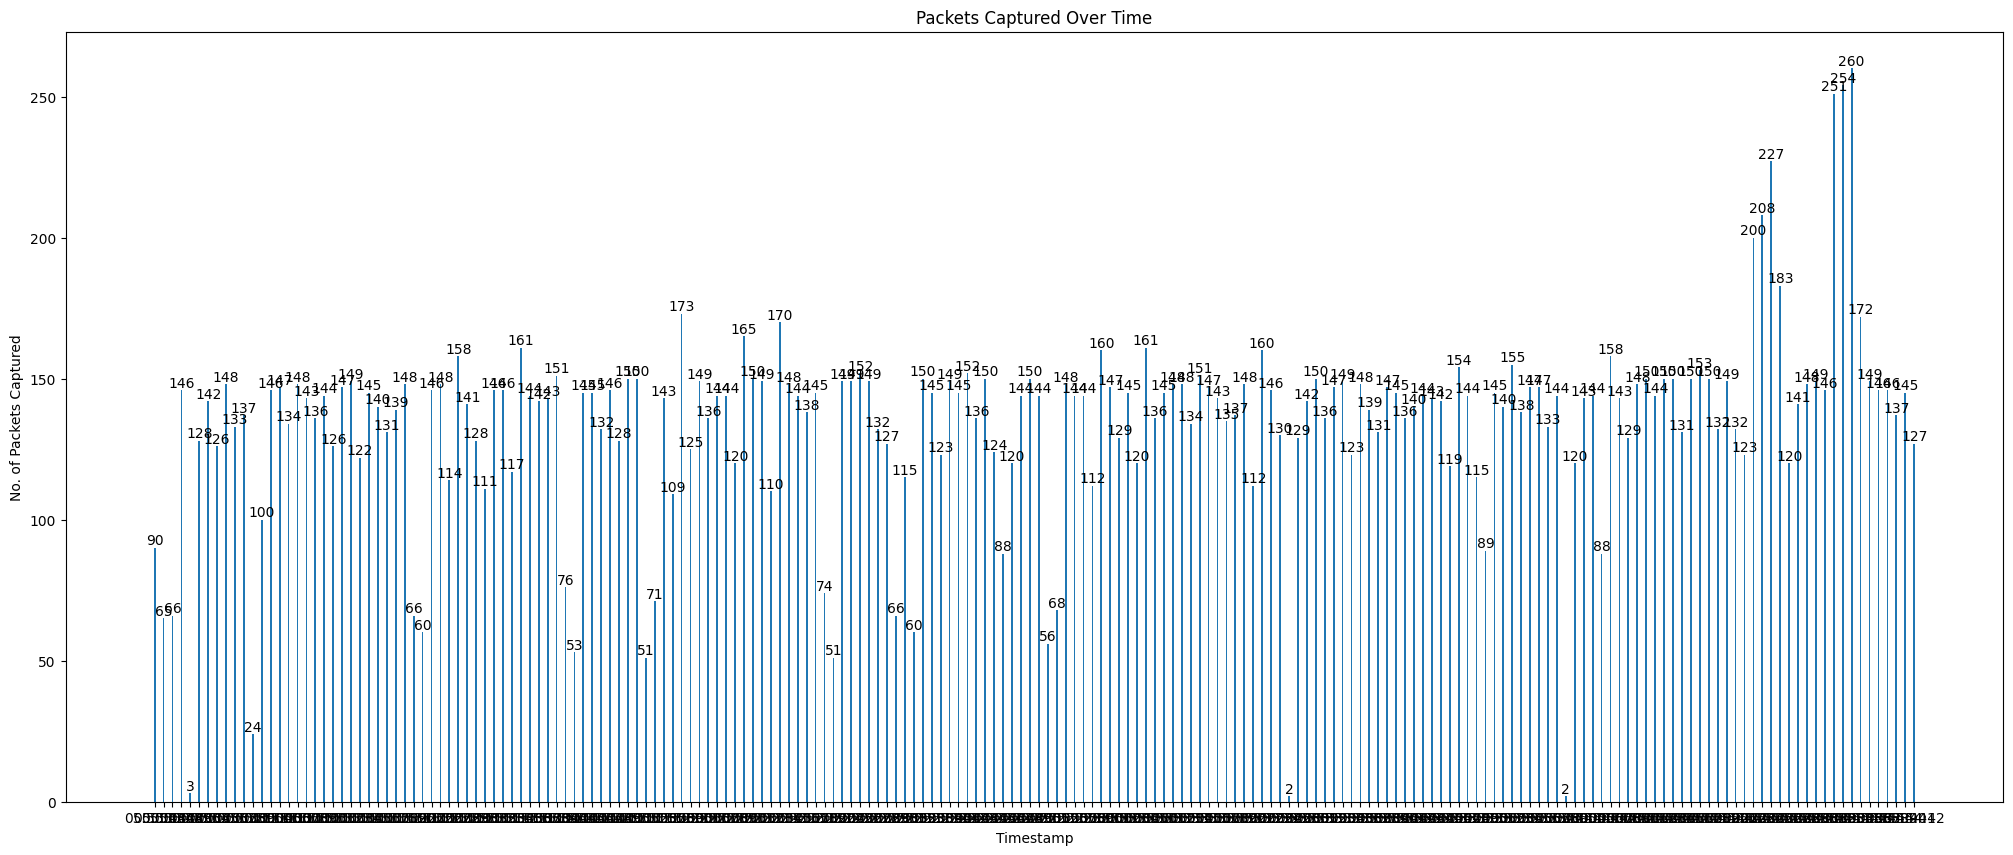

In [40]:
ts.plot_packet_timestamp(json_obj=result)

In [8]:
#slice.delete()

In [37]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

#Set end host to now plus 1 day
end_date = (datetime.now(timezone.utc) + timedelta(days=10)).strftime("%Y-%m-%d %H:%M:%S %z")

try:
    slice = fablib.get_slice(name=slice_name)

    slice.renew(end_date)
except Exception as e:
    print(f"Exception: {e}")